In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

In [55]:
import os
import h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from PIL import Image
from skimage.transform import resize
from skimage.util import img_as_ubyte, img_as_float
from sklearn.metrics import pairwise_distances
from utils import set_up_environment, prewhiten, maximum_center_crop, l2_normalize
from plot.heatmap import heatmap, annotate_heatmap
from attacks.pgd import PGDAttacker

In [5]:
set_up_environment(visible_devices='1')

In [7]:
model = tf.keras.models.load_model('../facenet_2d.h5')

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v1 (Model)  (None, 128)               22808144  
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 22,808,402
Trainable params: 258
Non-trainable params: 22,808,144
_________________________________________________________________


In [18]:
def _read_identity(identity):
    image_file = os.path.join('/projects/leelab3/image_datasets/vgg_face/test_preprocessed/',
                              identity,
                              'images.h5')
    with h5py.File(image_file, 'r') as f:
        images = f['images'][:]
    images_whitened = prewhiten(images).astype(np.float32)
    return images_whitened, images

In [19]:
identities = os.listdir('/projects/leelab3/image_datasets/vgg_face/test_preprocessed/')
training_images = []
viewing_images  = []

for i in range(5):
    identity = identities[i]
    batch_images, batch_viewing_images = _read_identity(identity)
    training_images.append(batch_images)
    viewing_images.append(batch_viewing_images)

In [91]:
colors = ['firebrick', 'forestgreen', 'skyblue', 'darkorange', 'purple']

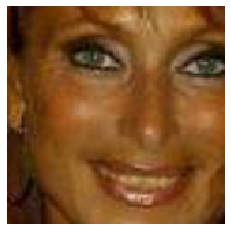

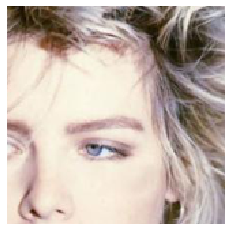

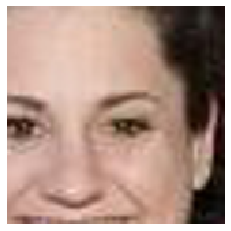

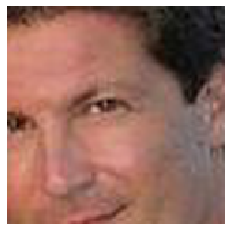

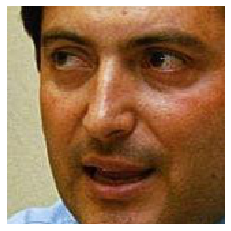

In [92]:
for i in range(len(viewing_images)):
    plt.figure()
    plt.imshow(viewing_images[i][10])
    plt.axis('off')
    plt.savefig(colors[i] + '.png', bbox_inches='tight')

In [44]:
embeddings = []
normalized_embeddings = []
for i in range(len(training_images)):
    batch_embeddings = model.predict(training_images[i],
                                     batch_size=64)
    embeddings.append(batch_embeddings)
    normalized_batch_embeddings = l2_normalize(batch_embeddings)
    normalized_embeddings.append(normalized_batch_embeddings)

In [74]:
def custom_axis():
    fig = plt.figure(dpi=150)
    ax = fig.gca()
    ax.grid(alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    ax.spines["top"].set_alpha(0.1)
    ax.spines["bottom"].set_alpha(1)
    ax.spines["right"].set_alpha(0.1)
    ax.spines["left"].set_alpha(1)
    return fig, ax

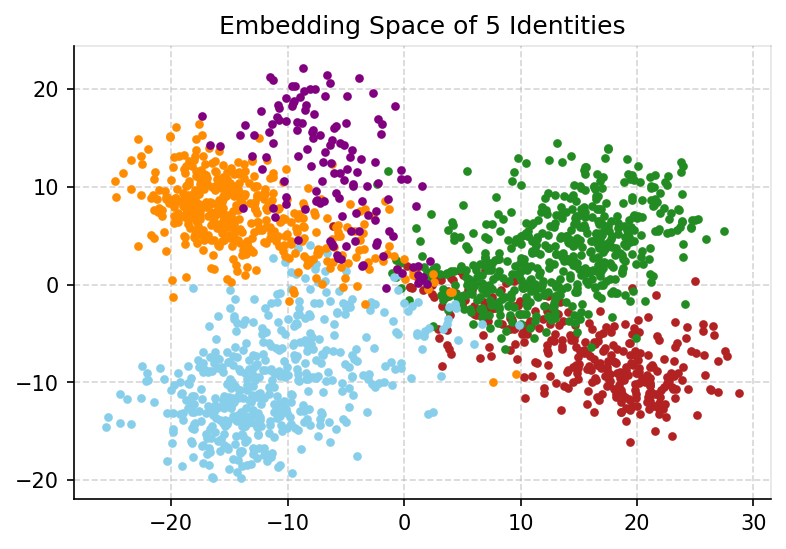

In [83]:
fig, ax = custom_axis()

for i in range(len(embeddings)):
    ax.scatter(x=embeddings[i][:, 0], y=embeddings[i][:, 1], color=colors[i], s=10)

_ = ax.set_title('Embedding Space of 5 Identities')
plt.savefig('embed.pdf')

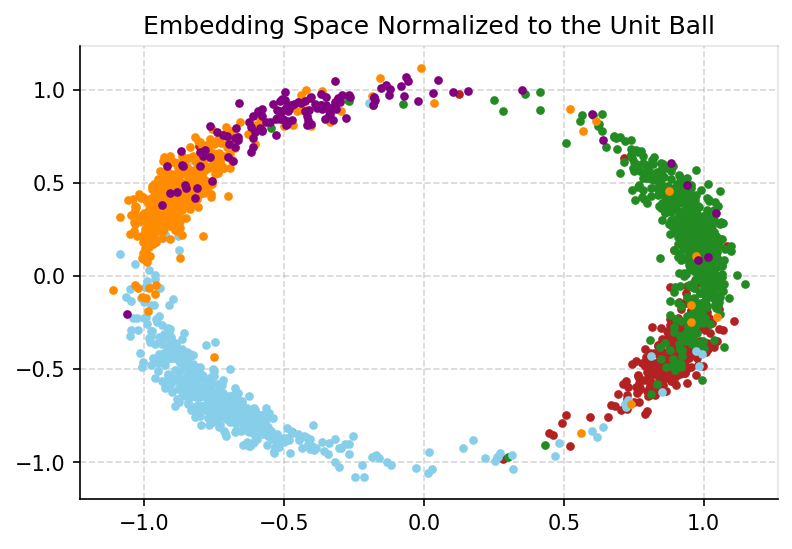

In [84]:
fig, ax = custom_axis()
for i in range(len(embeddings)):
    x_values = normalized_embeddings[i][:, 0]
    x_values = x_values + np.random.randn(x_values.shape[0]) * 0.05

    y_values = normalized_embeddings[i][:, 1]
    y_values = y_values + np.random.randn(y_values.shape[0]) * 0.05
    ax.scatter(x=x_values, y=y_values, color=colors[i], s=10)
_ = ax.set_title('Embedding Space Normalized to the Unit Ball')
plt.savefig('embed_norm.pdf')

In [56]:
attacker = PGDAttacker(model)

In [58]:
perturbed_images = attacker.self_distance_attack(training_images[-1],
                                                 epsilon=0.04,
                                                 verbose=True)

 33%|███▎      | 131/400 [00:45<01:32,  2.90it/s]

In [59]:
perturbed_embeddings = model.predict(perturbed_images,
                                     batch_size=64)
perturbed_embeddings_normalized = l2_normalize(perturbed_embeddings)

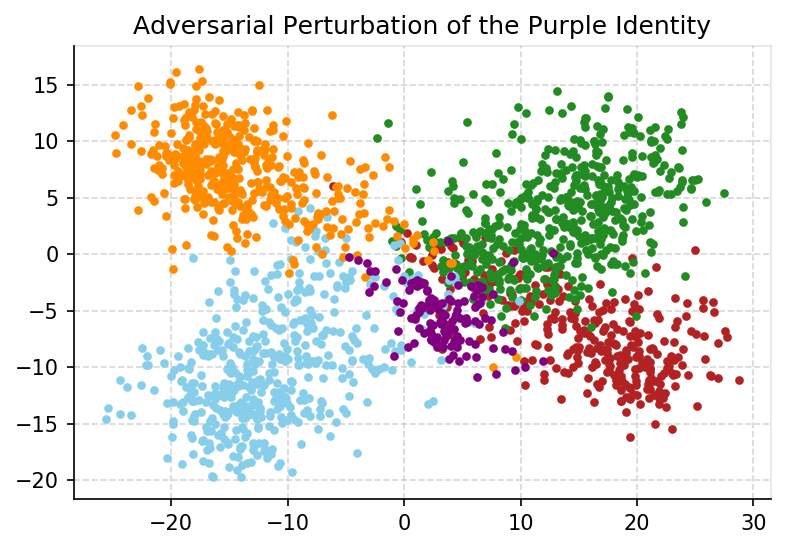

In [85]:
fig, ax = custom_axis()
for i in range(len(embeddings)):
    if i != len(embeddings) - 1:
        ax.scatter(x=embeddings[i][:, 0], y=embeddings[i][:, 1], color=colors[i], s=10)
    else:
        ax.scatter(x=perturbed_embeddings[:, 0], y=perturbed_embeddings[:, 1], color=colors[i], s=10)
_ = ax.set_title('Adversarial Perturbation of the Purple Identity')
plt.savefig('embed_adv.pdf')

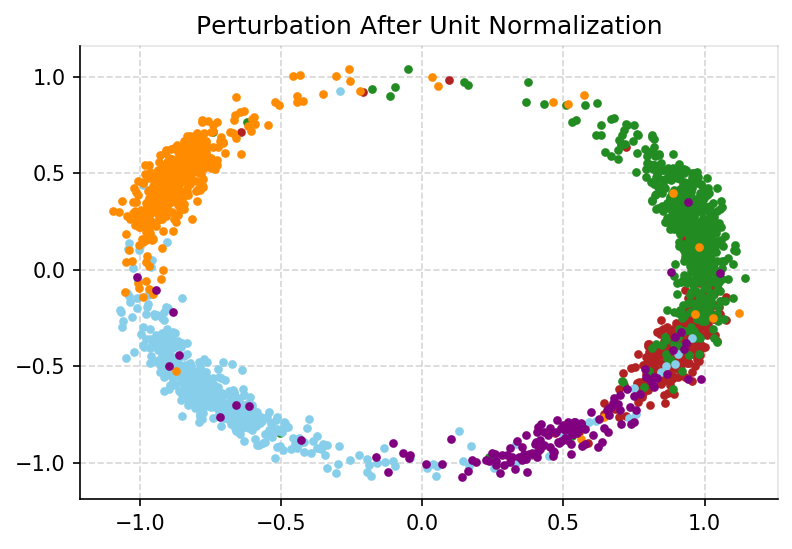

In [87]:
fig, ax = custom_axis()
for i in range(len(embeddings)):
    if i != len(embeddings) - 1:
        x_values = normalized_embeddings[i][:, 0]
        y_values = normalized_embeddings[i][:, 1]
    else:
        x_values = perturbed_embeddings_normalized[:, 0]
        y_values = perturbed_embeddings_normalized[:, 1]

    x_values = x_values + np.random.randn(x_values.shape[0]) * 0.05
    y_values = y_values + np.random.randn(y_values.shape[0]) * 0.05
    ax.scatter(x=x_values, y=y_values, color=colors[i], s=10)
_ = ax.set_title('Perturbation After Unit Normalization')
plt.savefig('embed_adv_norm.pdf')